In [ ]:
!pip install torch
!pip install emoji
!pip install tweet-preprocessor
!pip install transformers accelerate
!pip install scikit-learn

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emoji: filename=emoji-2.7.0-py2.py3-none-any.whl size=356563 sha256=111a90127c0358c1cd616de17054274d4e7ac262829f602d4ef6001b48c52764
  Stored in directory: /root/.cache/pip/wheels/41/11/48/5df0b9727d5669c9174a141134f10304d1d78a3b89a4676f3d
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import numpy as np
import pandas as pd
import emoji
import re
import preprocessor as p

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments

from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

In [ ]:
# Read the CSV file.
dataColumns = ['id', 'text', 'label']
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/train_all_tasks.csv', header=0)

dev_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/dev_task_a_entries.csv',
                  header=0)
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/test_task_a_entries.csv',
                  header=0)

In [ ]:
#train_df_taskA=train_df.drop(['label_vector'], axis=1)
train_df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [ ]:
print(f"Unique label test: {len(train_df['label_sexist'].unique()) == 2}")
print(f"not sexist example count: {len(train_df[train_df['label_sexist']=='not sexist']) == 10602}")
print(f"sexist example count: {len(train_df[train_df['label_sexist']=='sexist']) == 3398}")


Unique label test: True
not sexist example count: True
sexist example count: True


In [ ]:
def preprocess_text(text: str) -> str:
    """
    Function takes a raw text and performs the following processing steps:
    1. Lower case all text
    2. De-emoji the text
    3. Remove all hashtags, mentions, and urls
    4. Remove all non-alphabet characters except the followng punctuations: period, exclamation mark, and question mark
    """
    text = text.lower()
    text = emoji.demojize(text)
    text = p.clean(text)

    text = re.sub(r'[^a-z.!?]', ' ', text.replace('_','')).strip()

    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text=re.sub(r'[^\w\s]','',text)
    text=text.replace("[URL]","")
    text=text.replace("[USER]","")
    text=re.sub(r"[â€™ºðŸ‡˜Žµ±¤£‘Œ”œ]","",text)

    return text

train_df["text"] = train_df["text"].apply(preprocess_text)


In [ ]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):

    text = remove_between_square_brackets(text)
    return text

In [ ]:
train_df['text']=train_df['text'].apply(denoise_text)

In [ ]:
# using the train_test_split to split the data into training, validation, and
# test datasets
train, val = train_test_split(train_df, test_size = 0.3, random_state = 2023, stratify = train_df.label_sexist)
val, test = train_test_split(val, test_size = 0.5, random_state = 2023, stratify = val.label_sexist)

In [ ]:
# using pretrained distilbert-base-uncased tokeniser
tokeniserDistilBERT = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
train["label_sexist"] = train["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
val["label_sexist"] = val["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
test["label_sexist"] = test["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()

In [ ]:
trainingTokens = tokeniserDistilBERT(train["text"].tolist(),
                                     return_tensors = "pt",
                                     max_length = 48,
                                     truncation = True,
                                     padding = True)

trainingTokens["label"] = torch.tensor(train["label_sexist"].to_list())
# print(trainingTokens, len(trainingTokens))

validationTokens = tokeniserDistilBERT(val["text"].tolist(),
                                     return_tensors = "pt",
                                     max_length = 48,
                                     truncation = True,
                                     padding = True)
validationTokens["label"] = torch.tensor(val["label_sexist"].to_list())

testingTokens = tokeniserDistilBERT(test["text"].tolist(),
                                    return_tensors = "pt",
                                    max_length = 48,
                                    truncation = True,
                                    padding = True)

In [ ]:
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])


trainingDataset = Dataset(trainingTokens)
validationDataset = Dataset(validationTokens)
testingDataset = Dataset(testingTokens)


In [ ]:
distilBertModelA = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#pip uninstall -y transformers accelerate

In [ ]:
#pip install transformers accelerate

In [ ]:
trainingHyperParameters = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 5,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = True,
    load_best_model_at_end=True
)

# defining the trainer
trainerInstance = Trainer(
    model = distilBertModelA,
    args = trainingHyperParameters,
    train_dataset = trainingDataset,
    eval_dataset = validationDataset
)

# training the model with set hyperparameters
trainerInstance.train()

bertPredictions, _, _ = trainerInstance.predict(testingDataset)
bertPredictions = np.argmax(bertPredictions, axis = 1)

Epoch,Training Loss,Validation Loss
1,0.732300,0.734966
2,0.587700,0.629843
3,0.449900,0.661550
4,0.267900,0.767803
5,0.361500,0.770369


In [ ]:
print(classification_report(test["label_sexist"], bertPredictions))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1590
           1       0.77      0.46      0.58       510

    accuracy                           0.84      2100
   macro avg       0.81      0.71      0.74      2100
weighted avg       0.83      0.84      0.82      2100



In [ ]:
torch.save(distilBertModelA.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/distilBertModelA.pth')

In [ ]:
#loaded_model = DistilBertModel()
#loaded_model.load_state_dict(torch.load('distilBertModelA.pth'))
#loaded_model.eval()

### deberta-base

In [ ]:
#train, val = train_test_split(train_df, test_size = 0.3, random_state = 2023, stratify = train_df.label_sexist)
#val, test = train_test_split(val, test_size = 0.5, random_state = 2023, stratify = val.label_sexist)

#train["label_sexist"] = train["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
#val["label_sexist"] = val["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
#test["label_sexist"] = test["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()

#X=train_df.text.tolist()
#y=train_df.label_sexist.tolist()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = train_df.label_sexist)

X_train = train["text"].tolist()
y_train = train["label_sexist"].tolist()

X_test = test["text"].tolist()
y_test = test["label_sexist"].tolist()

X_val = val["text"].tolist()
y_val = val["label_sexist"].tolist()


from transformers import DebertaTokenizer, DebertaModel
import torch
# downloading the models
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

def encode_data(tokenizer, texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=48)
    inputs["labels"] = torch.tensor(labels)
    return inputs

train_encodings = encode_data(tokenizer, X_train, y_train)
test_encodings = encode_data(tokenizer, X_test, y_test)
val_encodings = encode_data(tokenizer, X_val, y_val)


In [ ]:
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])


trainingDataset = Dataset(train_encodings)
testingDataset = Dataset(test_encodings)
valDataset = Dataset(val_encodings)


In [ ]:
debertaModelA = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 5,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    learning_rate=2e-5,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=debertaModelA,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
)

trainer.train()

debertaPredictions, _, _ = trainer.predict(testingDataset)
debertaPredictions = np.argmax(debertaPredictions, axis = 1)

Epoch,Training Loss,Validation Loss
1,0.754800,0.673206
2,0.583700,0.603333
3,0.434600,0.713931
4,0.237600,0.832827
5,0.142900,1.021649


In [ ]:
print(classification_report(y_test, debertaPredictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1590
           1       0.77      0.55      0.64       510

    accuracy                           0.85      2100
   macro avg       0.82      0.75      0.77      2100
weighted avg       0.84      0.85      0.84      2100



In [ ]:
torch.save(debertaModelA.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/debertaModelA.pth')

### RoBertA large


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
robertaModelA = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

#train, val = train_test_split(train_df, test_size = 0.3, random_state = 2023, stratify = train_df.label_sexist)
#val, test = train_test_split(val, test_size = 0.5, random_state = 2023, stratify = val.label_sexist)

#train["label_sexist"] = train["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
#val["label_sexist"] = val["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
#test["label_sexist"] = test["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()

#X=train_df.text.tolist()
#y=train_df.label_sexist.tolist()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = train_df.label_sexist)

X_train = train["text"].tolist()
y_train = train["label_sexist"].tolist()

X_test = test["text"].tolist()
y_test = test["label_sexist"].tolist()

X_val = val["text"].tolist()
y_val = val["label_sexist"].tolist()

def encode_data(tokenizer, texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=48)
    inputs["labels"] = torch.tensor(labels)
    return inputs

train_encodings = encode_data(tokenizer, X_train, y_train)
test_encodings = encode_data(tokenizer, X_test, y_test)
val_encodings = encode_data(tokenizer, X_val, y_val)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Convert encodings to PyTorch tensors
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])


trainingDataset = Dataset(train_encodings)
testingDataset = Dataset(test_encodings)
valDataset = Dataset(val_encodings)

In [ ]:
training_args = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 2,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    learning_rate=2e-5,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=robertaModelA,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
)

trainer.train()

robertaPredictions, _, _ = trainer.predict(testingDataset)
robertaPredictions = np.argmax(robertaPredictions, axis = 1)

Epoch,Training Loss,Validation Loss
1,0.957500,1.006739
2,0.979300,0.948938


In [ ]:
print(classification_report(y_test, robertaPredictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1590
           1       0.00      0.00      0.00       510

    accuracy                           0.76      2100
   macro avg       0.38      0.50      0.43      2100
weighted avg       0.57      0.76      0.65      2100



In [ ]:
torch.save(robertaModelA.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/robertaModelA.pth')

### Electra


In [ ]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments
import torch

# Load the ELECTRA tokenizer and model
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
electraModelA = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator')


X_train = train["text"].tolist()
y_train = train["label_sexist"].tolist()

X_test = test["text"].tolist()
y_test = test["label_sexist"].tolist()

X_val = val["text"].tolist()
y_val = val["label_sexist"].tolist()

def encode_data(tokenizer, texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=48)
    inputs["labels"] = torch.tensor(labels)
    return inputs

train_encodings = encode_data(tokenizer, X_train, y_train)
test_encodings = encode_data(tokenizer, X_test, y_test)
val_encodings = encode_data(tokenizer, X_val, y_val)

# Prepare the training dataset
# Convert encodings to PyTorch tensors
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])


trainingDataset = Dataset(train_encodings)
testingDataset = Dataset(test_encodings)
valDataset = Dataset(val_encodings)

# Training arguments
training_args = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 5,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    learning_rate=2e-5,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=electraModelA,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
)

trainer.train()

# Predict labels for test data
electraPredictions, _, _ = trainer.predict(testingDataset)
electraPredictions = np.argmax(electraPredictions, axis = 1)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.701500,0.701612
2,0.633300,0.612829
3,0.543100,0.623987
4,0.501700,0.701786
5,0.413100,0.746051


In [ ]:
print(classification_report(y_test, electraPredictions))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1590
           1       0.78      0.45      0.57       510

    accuracy                           0.84      2100
   macro avg       0.81      0.71      0.74      2100
weighted avg       0.83      0.84      0.82      2100



In [ ]:
torch.save(electraModelA.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/electraModelA.pth')

### Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X_train = train["text"]
y_train = train["label_sexist"]

X_test = test["text"]
y_test = test["label_sexist"]

X_val = val["text"]
y_val = val["label_sexist"]

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
naive_bayes_classifierA = MultinomialNB()
naive_bayes_classifierA.fit(X_train_vectorized, y_train)

# Predict labels for the test set
y_pred = naive_bayes_classifierA.predict(X_test_vectorized)

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

#print(f"Accuracy: {accuracy:.2f}")
print(report)

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1590
           1       0.72      0.35      0.47       510

    accuracy                           0.81      2100
   macro avg       0.77      0.65      0.68      2100
weighted avg       0.80      0.81      0.78      2100



In [ ]:
import joblib

joblib.dump(naive_bayes_classifierA, '/content/drive/MyDrive/Colab Notebooks/Masters thesis/naive_bayes_modelA.pkl')

['/content/drive/MyDrive/Colab Notebooks/Masters thesis/naive_bayes_modelA.pkl']

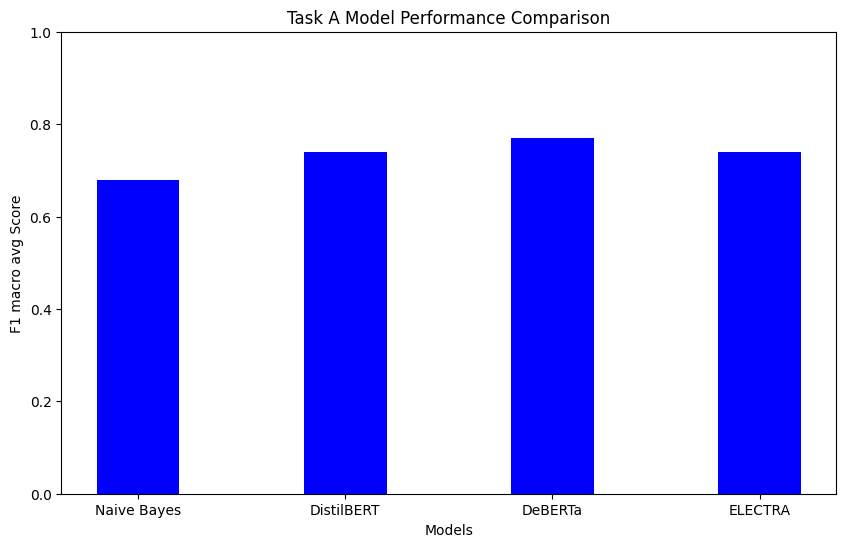

In [ ]:
import matplotlib.pyplot as plt

# List of model names
model_names = ["Naive Bayes", "DistilBERT", "DeBERTa", "ELECTRA"]

# List of accuracy values for each model
accuracy_values = [0.68, 0.74, 0.77, 0.74]  # Replace with actual accuracy values

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color='blue', width=0.4)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('F1 macro avg Score')
plt.title('Task A Model Performance Comparison')
plt.ylim(0, 1)  # Set y-axis limits

# Display the plot
plt.show()